# Using AMASS for training DNNs for Human Body and Motion
Just like [ImageNet](http://www.image-net.org/), AMASS is huge database ready to enable proper deep learning. However, instead of images, it consists of human body parameters, controlling the surface mesh of the [SMPL+H body model](http://mano.is.tue.mpg.de/). 

Here we provide basic tools to turn compressed AMASS numpy arrays that are as *.npz* files, into other suitable formats for deep learning frameworks. The outcomes are PyTorch readable *.pt* files, as well as *.h5* files
that are commonly used in machine learning fields. 

The provided data preparation code has three stages that could be flexibly modified for your own specific needs.

**Stage I** goes over the previously downloaded numpy npz files, subsamples them and saves them all into one place as PyTorch pt files.

**Stage II** uses PyTorch to apply all sorts of data augmentations 
in parallel on the original data and saves them as final HDF5 files.
HDF5 makes it possible to write on the file in chunks so that you wouldn't run out of memory
if you do a huge number of data augmentation steps. PyTorch also handles data augmentation in parallel so you should achieve your augmentation goal as fast as possible. 

**Stage III** simply turns the h5 files into pt files to be readily usable by PyTorch.

The progress at all stages is logged and could be inspected at any time during the process or later.
We also use an experiment ID that helps in referring to a specific data preparation run that can be traced back.

Dependencies to run this notebook:
- [Human Body Prior](https://github.com/nghorbani/human_body_prior)
- [PyTorch>=1.1.0](https://pytorch.org/)
- [PyTables](https://www.pytables.org/usersguide/installation.html)
- [tqdm](https://pypi.org/project/tqdm/2.2.3/)

Before you continue with this tutorial, it is recommended to first take a look at the [**AMASS Visualization**](01-AMASS_Visualization.ipynb) notebook.

In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import sys, os
import torch
import numpy as np

In [2]:
from human_body_prior.tools.omni_tools import makepath, log2file
from human_body_prior.tools.omni_tools import copy2cpu as c2c

We first pick an experiment ID that later helps us to identify the specific run of augmentations and data preparation. We also prepare a message about this specific experiment, that is going to be included in our log file as future notes. 

In [3]:
expr_code = 'VXX_SVXX_TXX' #VERSION_SUBVERSION_TRY

msg = ''' Initial use of standard AMASS dataset preparation pipeline '''

Then you have to download the body data npz files from https://amass.is.tue.mpg.de/datasets. Uncompress them at your desired location. The final folder structure should be like the following:

**amass_dir>sub_dataset>subjects>*_poses.npz**

Now specify the directory of the downloaded npz files and the final output folder for the prepared data, e.g. **work_dir**. At this location at each stage of the data processing pipeline, an appropriate folder is created. Moreover, the log file and a snapshot of the code is created.

In [4]:
amass_dir = 'PATH_TO_DOWNLOADED_NPZFILES/*/*_poses.npz'

work_dir = '/home/nghorbani/Downloads/VXX_SVXX_TXX'

logger = log2file(os.path.join(work_dir, '%s.log' % (expr_code)))
logger('[%s] AMASS Data Preparation Began.'%expr_code)
logger(msg)

[VXX_SVXX_TXX] AMASS Data Preparation Began.
 Initial use of standard AMASS dataset preparation pipeline 


Now you have to specify data splits for train/validation/test. Below is the recommended data splits by AMASS
for train/validation/test that chooses data for each split from non-overlapping datasets. 
One reason is to avoid similarity of markersets used for the original data.

In [5]:
amass_splits = {
    'vald': ['HumanEva', 'MPI_HDM05', 'SFU', 'MPI_mosh'],
    'test': ['Transitions_mocap', 'SSM_synced'],
    'train': ['CMU', 'MPI_Limits', 'TotalCapture', 'Eyes_Japan_Dataset', 'KIT', 
              'BML', 'EKUT', 'TCD_handMocap', 'ACCAD']
}
amass_splits['train'] = list(set(amass_splits['train']).difference(set(amass_splits['test'] + amass_splits['vald'])))

Now we have tools in place to run the preparation code:

In [6]:
from amass.prepare_data import prepare_amass
prepare_amass(amass_splits, amass_dir, work_dir, logger=logger)

Stage I: Fetch data from AMASS npz files
randomly selecting data points from HumanEva.
100%|██████████| 28/28 [00:00<00:00, 62.69it/s]
randomly selecting data points from MPI_HDM05.
100%|██████████| 215/215 [00:06<00:00, 32.72it/s]
randomly selecting data points from SFU.
100%|██████████| 44/44 [00:00<00:00, 60.63it/s]
randomly selecting data points from MPI_mosh.
100%|██████████| 77/77 [00:00<00:00, 89.65it/s] 
randomly selecting data points from Transitions_mocap.
100%|██████████| 110/110 [00:00<00:00, 113.36it/s]
randomly selecting data points from SSM_synced.
100%|██████████| 30/30 [00:00<00:00, 208.67it/s]
randomly selecting data points from TotalCapture.
100%|██████████| 37/37 [00:00<00:00, 37.97it/s]
randomly selecting data points from KIT.
100%|██████████| 4232/4232 [00:38<00:00, 110.27it/s]
randomly selecting data points from MPI_Limits.
100%|██████████| 35/35 [00:00<00:00, 35.82it/s]
randomly selecting data points from TCD_handMocap.
100%|██████████| 62/62 [00:00<00:00, 99.76

## Visualize the prepared data
Now that final PyTorch .pt files are prepared we can try to open them with PyTorch wich a dataloader:

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import glob 

class AMASS_DS(Dataset):
    """AMASS: a pytorch loader for unified human motion capture dataset. http://amass.is.tue.mpg.de/"""

    def __init__(self, dataset_dir, num_betas=16):

        self.ds = {}
        for data_fname in glob.glob(os.path.join(dataset_dir, '*.pt')):
            k = os.path.basename(data_fname).replace('.pt','')
            self.ds[k] = torch.load(data_fname)
        self.num_betas = num_betas

    def __len__(self):
       return len(self.ds['trans'])

    def __getitem__(self, idx):
        data =  {k: self.ds[k][idx] for k in self.ds.keys()}
        data['root_orient'] = data['pose'][:3]
        data['pose_body'] = data['pose'][3:66]
        data['pose_hand'] = data['pose'][66:]
        data['betas'] = data['betas'][:self.num_betas]

        return data

num_betas = 16 # number of body parameters
testsplit_dir = os.path.join(work_dir, 'stage_III', 'test')

ds = AMASS_DS(dataset_dir=testsplit_dir, num_betas=num_betas)
print('Test split has %d datapoints.'%len(ds))

batch_size = 5
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=5)

Test split has 867 datapoints.


We can use the tutorial in [**AMASS Visualization**](01-AMASS_Visualization.ipynb) to visualize the data

In [8]:
import trimesh
from human_body_prior.tools.omni_tools import colors
from human_body_prior.mesh import MeshViewer
from human_body_prior.mesh.sphere import points_to_spheres
from human_body_prior.tools.omni_tools import apply_mesh_tranfsormations_
from human_body_prior.tools.visualization_tools import imagearray2file
from notebook_tools import show_image

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

In [9]:
from human_body_prior.body_model.body_model import BodyModel
bm_path = '../body_models/smplh/male/model.npz'

bm = BodyModel(bm_path=bm_path, num_betas=num_betas, batch_size=batch_size)
faces = c2c(bm.f)

bdata = next(iter(dataloader))
body_v = bm.forward(pose_body=bdata['pose_body'], betas=bdata['betas']).v

In [10]:
view_angles = [0, 180, 90, -90]
images = np.zeros([len(view_angles), batch_size, 1, imw, imh, 3])
for cId in range(0, batch_size):

    orig_body_mesh = trimesh.Trimesh(vertices=c2c(body_v[cId]), faces=c2c(bm.f), vertex_colors=np.tile(colors['grey'], (6890, 1)))

    for rId, angle in enumerate(view_angles):
        if angle != 0: apply_mesh_tranfsormations_([orig_body_mesh], trimesh.transformations.rotation_matrix(np.radians(angle), (0, 1, 0)))
        mv.set_meshes([orig_body_mesh], group_name='static')
        images[rId, cId, 0] = mv.render()

        if angle != 0: apply_mesh_tranfsormations_([orig_body_mesh], trimesh.transformations.rotation_matrix(np.radians(-angle), (0, 1, 0)))


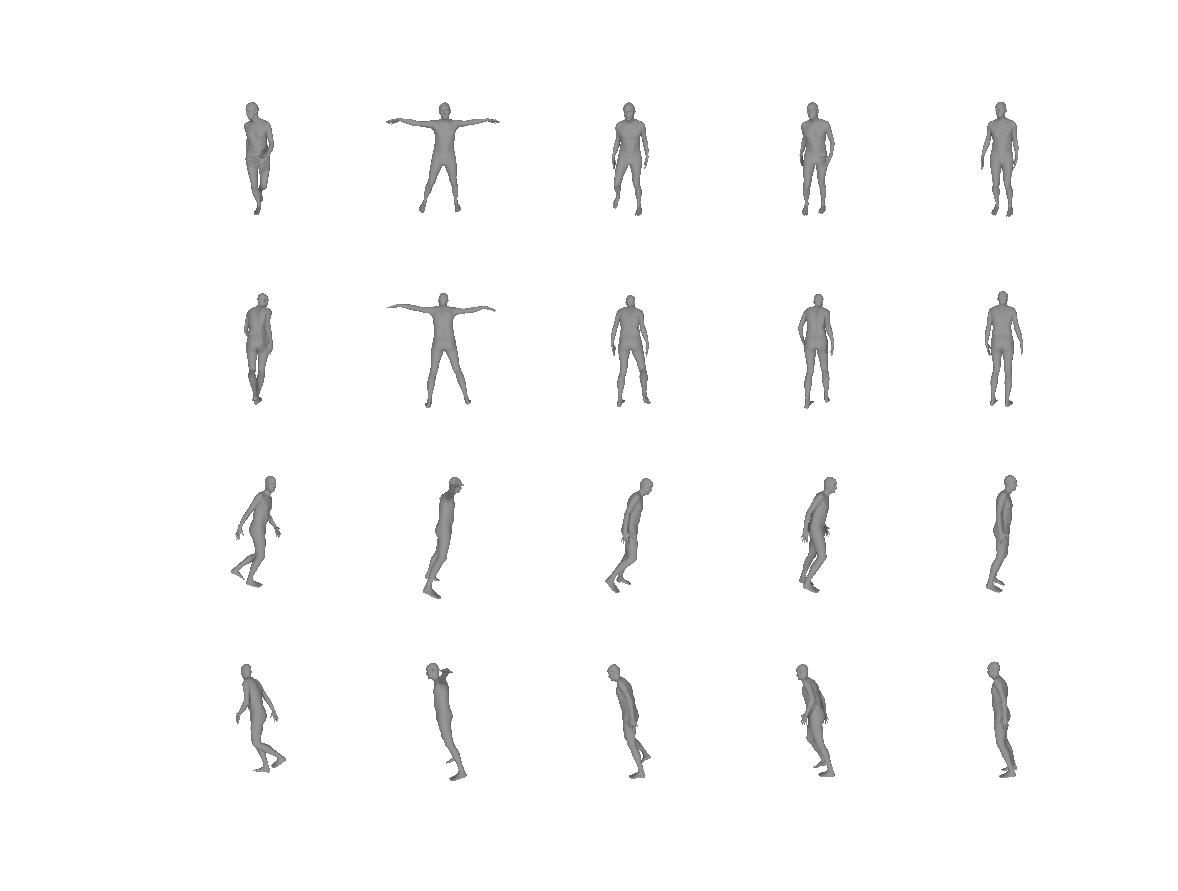

In [11]:
img = imagearray2file(images)
show_image(np.array(img)[0])

In the above image each column is a data point and at each row we rotate the body to visualize it in different angles.
AMASS has been recently used to train a human body prior for 2D-to-3D expressive human body image lifting. Take a look at the paper [Expressive Body Capture: 3D Hands, Face, and Body from a Single Image](https://smpl-x.is.tue.mpg.de/en) and the [VPoser github page](https://github.com/nghorbani/human_body_prior) for further information. VPoser is also capable of generating new body poses for SMPL-H model.